# Морфологический анализ и нормализация текста с помощью Python3

In [39]:
from json import dump
from pymystem3 import Mystem
from re import findall
from Levenshtein import distance
import string

m = Mystem()

with open('sbory/My.txt', encoding='UTF-8') as text:
    text = text.read()

In [5]:
print(f'В тексте романа Замятина «Мы» – {len(text)} символов.')

В тексте романа Замятина «Мы» – 298125 символов.


In [13]:
text[182:420]

'Через 120 дней заканчивается постройка ИНТЕГРАЛА. Близок великий, исторический час, когда первый ИНТЕГРАЛ взовьется в мировое пространство. Тысячу лет тому назад ваши героические предки покорили власти Единого Государства весь земной шар.'

Мы можем просмотреть интересующий нас отрезок текста, задав символ отсчета и символ конца. В данном случае показан текст с 182 по 420 (не включительно) символ.

Предположим, нам интересно, сколько раз встречается слово _интеграл_. Сделаем поисковый запрос.

In [19]:
query = 'интеграл'

print(f'Слово «{query}» встретилось {len(findall(query, text))} раз(а).')

Слово «интеграл» встретилось 2 раз(а).


- Как странно! Всего лишь два раза – не маловато ли это для такого важного слова?
- Почему результат таков? 
- Как исправить ситуацию?

Важно понимать, что в реальном тексте встречаются разные написания одного и того же слова:
- опечатки (интыграл)
- регистр символов (ИНТЕГРАЛ или Интеграл и т. д.)
- с "приклеенными" знаками пунктуации (ИНТЕГРАЛ! и т. д.)
- разные формы слова (ИНТЕГРАЛУ, ИНТЕГРАЛОМ, Интегралы...)

Чтобы мы могли получить правильную статистику, нужно устранить эти факторы, то есть __нормализовать__ текст. Сделаем это.

## Опечатки

Удалить опечатки не так просто. Как это можно было бы сделать, на ваш взгляд?

Возможное решение: измерить, насколько отличается каждый кандидат с потенциальной опечаткой от правильного написания. Это можно сделать, измерив __расстояние Левенштейна__.

In [25]:
ideal = 'интеграл'
candidates = ['интыграл', 'интеграл', 'iнтеrрал', 'канарейка', 'суп']

for c in candidates:
    print(f'Расстояние Левенштейна между «{ideal}» и «{c}» – {distance(ideal, c)}.')

Расстояние Левенштейна между «интеграл» и «интыграл» – 1.
Расстояние Левенштейна между «интеграл» и «интеграл» – 0.
Расстояние Левенштейна между «интеграл» и «iнтеrрал» – 2.
Расстояние Левенштейна между «интеграл» и «канарейка» – 7.
Расстояние Левенштейна между «интеграл» и «суп» – 8.


Видим, что, чем больше расстояние Левенштейна между интересующим нас словом и кандидатом с ошибкой, тем менее вероятно, что слова совпадают. Наоборот, если расстояние небольшое (например, 1), то можно думать, что допущена опечатка.

## Регистр символов

Важно, чтобы текст состоял из символов одного регистра: либо заглавные буквы, либо строчные. Выберем строчные, приведем всё к этому регистру.

In [32]:
text[182:630]

'Через 120 дней заканчивается постройка ИНТЕГРАЛА. Близок великий, исторический час, когда первый ИНТЕГРАЛ взовьется в мировое пространство. Тысячу лет тому назад ваши героические предки покорили власти Единого Государства весь земной шар. Вам предстоит еще более славный подвиг: стеклянным, электрическим, огнедышащим ИНТЕГРАЛОМ проинтегрировать бесконечное уравнение Вселенной. Вам предстоит благодетельному игу разума подчинить неведомые существа'

In [36]:
sample = text[182:630].lower()

print(sample)

через 120 дней заканчивается постройка интеграла. близок великий, исторический час, когда первый интеграл взовьется в мировое пространство. тысячу лет тому назад ваши героические предки покорили власти единого государства весь земной шар. вам предстоит еще более славный подвиг: стеклянным, электрическим, огнедышащим интегралом проинтегрировать бесконечное уравнение вселенной. вам предстоит благодетельному игу разума подчинить неведомые существа


## Пунктуация

Как можно было бы решить эту проблему?

Например, задать длинный список с символами типа запятой, тире, дефиса, точки... А потом удалить все эти символы из текста.

In [55]:
sample_no_punct = sample

for p in string.punctuation + '.,':
    sample_no_punct = sample_no_punct.replace(p, '')

print(sample_no_punct)

через 120 дней заканчивается постройка интеграла близок великий исторический час когда первый интеграл взовьется в мировое пространство тысячу лет тому назад ваши героические предки покорили власти единого государства весь земной шар вам предстоит еще более славный подвиг стеклянным электрическим огнедышащим интегралом проинтегрировать бесконечное уравнение вселенной вам предстоит благодетельному игу разума подчинить неведомые существа


Чем плох такой способ?

In [150]:
word = 'по-плохому?'
res = word
for p in string.punctuation + '.,':
    res = res.replace(p, '')

print(f'«{word}» превратится в «{res}»')

«по-плохому?» превратится в «поплохому»


## Лемматизация

До текущего момента мы работали с довольно тривиальными задачами: убрать лишние символы, привести всё к одному регистру... а как быть с грамматикой? Простыми операциями с символами тут не обойтись!

Для начала определимся с целью. Мы хотим, чтобы можно было подсчитать частотность одного слова и сравнить ее с частотностью другого. Нам мешает то, что в русском языке у знаменательных частей речи есть словоизменение. Что нужно сделать, чтобы преодолеть эту проблему?

Например, привести все слова в тексте к начальной форме (для сущ. – им. п. ед. ч., для глаголов – инфинитив и т. д.). Для решения этой задачи – __лемматизации__ – уже создали разнообразные алгоритмы. Воспользуемся одним из них.

In [58]:
''.join(m.lemmatize(sample_no_punct))

'через 120 день заканчиваться постройка интеграл близкий великий исторический час когда первый интеграл взвиваться в мировой пространство тысяча год то назад ваш героический предок покорять власть единый государство весь земной шар вы предстоять еще более славный подвиг стеклянный электрический огнедышащий интеграл проинтегрировать бесконечный уравнение вселенная вы предстоять благодетельный иго разум подчинять неведомый существо\n'

Ура! Кажется, все препятствия устранены. Теперь повторим все сделанное выше (кроме обнаружения опечаток) со всем текстом и посмотрим на результаты.

In [100]:
lemmatized_text = text

for p in string.punctuation + '.,':
    lemmatized_text = lemmatized_text.replace(p, '')

lemmatized_text = ''.join(m.lemmatize(lemmatized_text))

In [78]:
print(lemmatized_text[:501])

евгений замятин

мы

  
запись 1я
конспект объявление мудрый из линия поэма

   я просто списывать  слово в слово  то что сегодня напечатать в государственный газета
   через 120 день заканчиваться постройка интеграл близкий великий исторический час когда первый интеграл взвиваться в мировой пространство тысяча год то назад ваш героический предок покорять власть единый государство весь земной шар вы предстоять еще более славный подвиг стеклянный электрический огнедышащий интеграл проинтегрировать


In [66]:
query = 'интеграл'

print(f'Слово «{query}» встретилось {len(findall(query, lemmatized_text))} раз(а).')

Слово «интеграл» встретилось 60 раз(а).


Это гораздо правдоподобней! С чем сравним частотность этого слова?

In [81]:
query = 'любить'

print(f'Слово «{query}» встретилось {len(findall(query, lemmatized_text))} раз(а).')

Слово «любить» встретилось 26 раз(а).


# Облако слов

Сравнивать частотность двух слов, конечно, интересно, но при таком анализе мы видим лишь полкартины. Чтобы увидеть картину более полную, хотелось бы взглянуть на _все_ слова и увидеть, какие из них наиболее частотны.

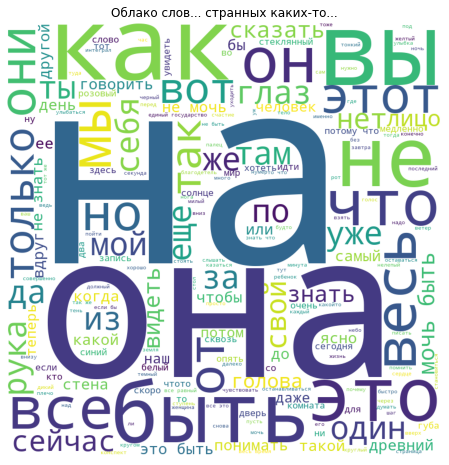

In [92]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

wc = WordCloud(background_color="white", repeat=True, height=800, width=800)
wc.generate(lemmatized_text)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc)
plt.axis("off") 
plt.title('Облако слов... странных каких-то...')
plt.show()

Хм, что-то не так. Как вам результат?

## Стоп-слова

В любом языке есть служебные слова типа союзов или предлогов; есть местоимения. Все они встречаются очень часто – почему?

Мы и так знаем, что в любом тексте их будет много. Чтобы посмотреть на распределение менее предсказуемых единиц (например, существительных), эти __стоп-слова__ часто игнорируют при лингвистическом анализе.

Специалисты уже составили список стоп-слов для многих языков, в том числе для русского. Воспользуемся им: будем игнорировать стоп-слова при подсчете частотности.

In [110]:
from nltk.corpus import stopwords

stops = set(stopwords.words('russian') + ['это', 'весь', 'который', 'мочь', 'свой', 'быть'])

print('Стоп-слова:', stops)

Стоп-слова: {'всех', 'этой', 'ни', 'может', 'мой', 'тут', 'о', 'этот', 'же', 'чем', 'другой', 'него', 'какой', 'себя', 'нибудь', 'были', 'он', 'бы', 'чтоб', 'иногда', 'за', 'такой', 'с', 'тогда', 'разве', 'все', 'под', 'почти', 'вас', 'если', 'они', 'им', 'потом', 'перед', 'по', 'ей', 'какая', 'много', 'их', 'будто', 'да', 'потому', 'куда', 'над', 'об', 'мне', 'в', 'хоть', 'быть', 'свою', 'этого', 'три', 'она', 'его', 'при', 'от', 'без', 'нет', 'был', 'себе', 'у', 'вам', 'я', 'нас', 'который', 'на', 'ты', 'нее', 'этом', 'можно', 'но', 'всего', 'них', 'тебя', 'после', 'том', 'во', 'через', 'теперь', 'для', 'надо', 'только', 'тем', 'было', 'один', 'из', 'там', 'ему', 'хорошо', 'ее', 'была', 'к', 'всю', 'вы', 'как', 'эту', 'лучше', 'ничего', 'сам', 'никогда', 'еще', 'конечно', 'ним', 'тоже', 'больше', 'мочь', 'то', 'эти', 'не', 'совсем', 'свой', 'про', 'мы', 'даже', 'того', 'ну', 'меня', 'так', 'чего', 'ли', 'зачем', 'нельзя', 'что', 'или', 'всегда', 'вот', 'весь', 'ж', 'и', 'уже', 'здесь

In [121]:
lemmatized_text_no_stops = [token for token in lemmatized_text.split() if token not in stops]

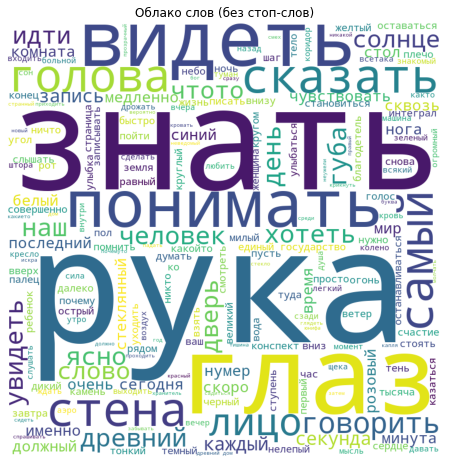

In [122]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

wc = WordCloud(background_color="white", repeat=True, height=800, width=800)
wc.generate(' '.join(lemmatized_text_no_stops))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc)
plt.axis("off") 
plt.title('Облако слов (без стоп-слов)')
plt.show()

Попробуем интерпретировать результаты. Почему это – самые частотные не-стоп-слова?

# Игры с морфологией

Можем ли мы использовать морфологический анализатор как-то еще?

Конечно! Попробуем посмотреть, какую информацию способен дать анализатор.

In [127]:
m.analyze('собака')

[{'analysis': [{'lex': 'собака', 'wt': 1, 'gr': 'S,жен,од=им,ед'}],
  'text': 'собака'},
 {'text': '\n'}]

Видно, что анализатор выдает информацию о части речи (S), роде (жен), одушевленности (од), падеже (им) и числе (ед).

Как можно использовать эту информацию? Придумайте гипотезы!

Например, давайте посмотрим, чего больше в романе Замятина: существительных или глаголов. (Как вы думаете?)

In [143]:
from collections import Counter
from pymorphy2 import MorphAnalyzer

pm = MorphAnalyzer()

res = []
tokenised_text = word_tokenize(text)

for word in tokenised_text:
    res.append(pm.parse(word))

count = Counter()
top_nouns = Counter()
top_adjectives = Counter()
top_verbs = Counter()

for token in res:
    count[token[0].tag.POS] += 1 #считаем все части речи
    all_tokens += 1 #считаем все токены

for c in count:
    if c != None:
        print('Доля слов %s – %s.' % (c, count[c] / all_tokens))

Доля слов NOUN – 0.15780451569719034.
Доля слов NPRO – 0.07480449937145936.
Доля слов ADJF – 0.09901555842162833.
Доля слов PREP – 0.07031492335069303.
Доля слов PRCL – 0.05013631985372145.
Доля слов VERB – 0.08246126720323903.
Доля слов CONJ – 0.07679623855158114.
Доля слов ADVB – 0.0631152759864823.
Доля слов PRTS – 0.002775374267382822.
Доля слов ADJS – 0.007738396486702692.
Доля слов INFN – 0.014333991804483045.
Доля слов PRTF – 0.00941994677811699.
Доля слов PRED – 0.004979347950304475.
Доля слов GRND – 0.0037712438574437172.
Доля слов COMP – 0.004228364325012652.
Доля слов INTJ – 0.001681550291414298.
Доля слов NUMR – 0.0032161690039671526.


Больше всего существительных (0.157), затем идут полные формы прилагательных (0.099), и глагол лишь на третьем месте (0.082). Интересно! Как можно проинтерпретировать такое «распределение сил»?

А какие слова из этой троицы наиболее частотны?

In [137]:
print(
    'Топ-10 существительных: %s.\n\nТоп-10 полных прилагательных: %s\n\nТоп-10 глаголов: %s' % 
    (top_nouns.most_common(10), top_adjectives.most_common(10), top_verbs.most_common(10))
)

Топ-10 существительных: [('глаза', 103), ('руки', 62), ('раз', 61), ('лицо', 51), ('губы', 49), ('время', 48), ('руку', 46), ('секунду', 46), ('нее', 46), ('дверь', 44)].

Топ-10 полных прилагательных: [('все', 529), ('один', 80), ('этот', 59), ('какой-то', 49), ('всех', 47), ('тот', 46), ('весь', 45), ('эти', 43), ('одно', 41), ('мои', 41)]

Топ-10 глаголов: [('было', 171), ('может', 117), ('знаю', 102), ('был', 101), ('вижу', 50), ('были', 49), ('будет', 48), ('могу', 48), ('была', 42), ('увидел', 39)]


Стоп-слова всё портят! Избавимся от них. Также лемматизируем текст.

In [144]:
res_tokenized = [pm.parse(token) for token in text.split() if token not in stops]

count = Counter()
top_nouns = Counter()
top_adjectives = Counter()
top_verbs = Counter()

for token in res_tokenized:
    count[token[0].tag.POS] += 1 #считаем все части речи
    if token[0].tag.POS == 'NOUN': #считаем топ существительных
        top_nouns[token[0].normal_form] += 1
    elif token[0].tag.POS == 'ADJF': #считаем топ полных прилагательных
        top_adjectives[token[0].normal_form] += 1
    elif token[0].tag.POS == 'VERB': #считаем топ глаголов
        top_verbs[token[0].normal_form] += 1
        
print(
    'Топ-10 существительных: %s.\n\nТоп-10 полных прилагательных: %s\n\nТоп-10 глаголов: %s' % 
    (top_nouns.most_common(10), top_adjectives.most_common(10), top_verbs.most_common(10))
)

Топ-10 существительных: [('рука', 114), ('глаз', 97), ('лицо', 57), ('день', 55), ('дверь', 51), ('время', 46), ('стена', 45), ('запись', 44), ('голова', 41), ('секунда', 37)].

Топ-10 полных прилагательных: [('один', 155), ('какой-то', 128), ('мой', 121), ('весь', 120), ('самый', 114), ('свой', 77), ('наш', 74), ('такой', 62), ('единый', 59), ('древний', 58)]

Топ-10 глаголов: [('мочь', 104), ('видеть', 58), ('знать', 57), ('сказать', 51), ('хотеть', 47), ('говорить', 45), ('быть', 43), ('идти', 41), ('увидеть', 35), ('стать', 33)]


# N-граммы

До этого момента мы смотрели на отдельные слова. Но справедливо ли это? Ведь в любом тексте слова _соседствуют_ друг с другом, и некоторое такое соседство вовсе не случайно. В чем эта неслучайность может проявляться?

- идиоматизированные единицы
- устойчивые сочетания (__коллокации__)
- сложные слова (тем не менее; то, что)

N-граммы – способ изучения таких сочетаний. Вместо N можно подставить любое число: 2-граммы (биграммы), 3-граммы (триграммы) и т. д.

Изучим биграммы и триграммы в тексте Замятина.

In [151]:
from nltk.util import ngrams

text_no_punct = text

for p in string.punctuation + '.,':
    text_no_punct = text_no_punct.replace(p, '')


res_tokenized_with_stops = text_no_punct.split()
res_tokenized_no_stops = [token for token in res_tokenized_with_stops if token not in stops]

bigrams = Counter([' '.join(grams) for grams in ngrams(res_tokenized_with_stops,2)]) #собираем биграмы
trigrams = Counter([' '.join(grams) for grams in ngrams(res_tokenized_with_stops,3)]) #собираем триграмы

print('Топ-25 биграм: %s.\n\nТоп-25 триграм: %s' % (bigrams.most_common(25), trigrams.most_common(25)))

Топ-25 биграм: [('у меня', 86), ('может быть', 71), ('и я', 64), ('что я', 61), ('я не', 61), ('потому что', 43), ('и все', 42), ('все это', 42), ('и не', 42), ('И вот', 40), ('И я', 39), ('так же', 38), ('не знаю', 38), ('Я не', 37), ('во мне', 36), ('если бы', 36), ('не могу', 36), ('на меня', 36), ('Единого Государства', 34), ('это было', 31), ('все равно', 30), ('и в', 28), ('то что', 27), ('как я', 27), ('ко мне', 27)].

Топ-25 триграм: [('так же как', 11), ('в самом деле', 11), ('у меня в', 10), ('до сих пор', 10), ('я не могу', 9), ('одно и то', 9), ('и то же', 9), ('раз в жизни', 8), ('в Древнем Доме', 8), ('и тотчас же', 8), ('или может быть', 8), ('я не знаю', 8), ('Я не могу', 8), ('одну и ту', 7), ('и ту же', 7), ('о том что', 7), ('если бы я', 7), ('в Бюро Хранителей', 7), ('и может быть', 7), ('у меня на', 7), ('первый раз в', 6), ('в глаза мне', 6), ('все так же', 6), ('то же самое', 6), ('неведомые мои читатели', 6)]


Cтоп-слова не убраны. А что будет без них?

In [152]:
bigrams = Counter([' '.join(grams) for grams in ngrams(res_tokenized_no_stops,2)]) #собираем биграмы
trigrams = Counter([' '.join(grams) for grams in ngrams(res_tokenized_no_stops,3)]) #собираем триграмы

print('Топ-25 биграм: %s.\n\nТоп-25 триграм: %s' % (bigrams.most_common(25), trigrams.most_common(25)))

Топ-25 биграм: [('Единого Государства', 34), ('Я знаю', 17), ('самом деле', 16), ('Не знаю', 13), ('Бюро Хранителей', 12), ('сих пор', 11), ('Я увидел', 10), ('Древнего Дома', 10), ('Я видел', 10), ('Единое Государство', 9), ('Двухсотлетней Войны', 8), ('мои читатели', 8), ('вниз вниз', 8), ('Древнем Доме', 8), ('И знаю', 8), ('Я хочу', 8), ('Я могу', 8), ('одну ту', 7), ('неведомые мои', 7), ('т е', 7), ('двери шкафа', 7), ('И ясно', 7), ('Я вижу', 7), ('Вы понимаете', 7), ('Строитель Интеграла', 7)].

Топ-25 триграм: [('неведомые мои читатели', 6), ('белые острые зубы', 3), ('Я пожал плечами', 3), ('время Двухсотлетней Войны', 3), ('вниз вниз вниз', 3), ('острый насмешливый треугольник', 3), ('крепко сжал руку', 3), ('зеркальной дверью шкафа', 3), ('всем сойти ума', 3), ('лицо Второго Строителя', 3), ('диком состоянии свободы', 2), ('Единого Государства Это', 2), ('Да здравствует Единое', 2), ('здравствует Единое Государство', 2), ('Я пишу чувствую', 2), ('пишу чувствую горят', 2), (

Попробуем проинтерпретировать?

# https://rusvectores.org/ru/